In [63]:
import networkx as nx
import matplotlib.pyplot as plt
import argparse
from node2vec import Node2Vec

In [64]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

def visualize_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))  # Dodanie węzłów dla zmiennych
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))  # Dodanie krawędzi między zmiennymi w tej samej klauzuli
    pos = nx.spring_layout(G)  # Ustalenie układu wizualizacji
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.show()

def generate_node_embeddings(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))

    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model, G

In [65]:
nazwa_pliku = "DIMACS_files/turbo_easy/example.cnf"
nazwa_pliku_1 = "DIMACS_files/turbo_easy/example_1.cnf"

num_vars, clauses = read_dimacs_cnf(nazwa_pliku)
num_vars_1, clauses_1 = read_dimacs_cnf(nazwa_pliku_1)
print(num_vars)
print(clauses)
print(num_vars_1)
print(clauses_1)

4
[[-1, -2, 3], [2, 3], [1, -3, 4]]
60
[[39, 40, 1], [-39, -40, 1], [39, -40, -1], [-39, 40, -1], [1, 41, 2], [-1, -41, 2], [1, -41, -2], [-1, 41, -2], [2, 42, 3], [-2, -42, 3], [2, -42, -3], [-2, 42, -3], [3, 43, 4], [-3, -43, 4], [3, -43, -4], [-3, 43, -4], [4, 44, 5], [-4, -44, 5], [4, -44, -5], [-4, 44, -5], [5, 45, 6], [-5, -45, 6], [5, -45, -6], [-5, 45, -6], [6, 46, 7], [-6, -46, 7], [6, -46, -7], [-6, 46, -7], [7, 47, 8], [-7, -47, 8], [7, -47, -8], [-7, 47, -8], [8, 48, 9], [-8, -48, 9], [8, -48, -9], [-8, 48, -9], [9, 49, 10], [-9, -49, 10], [9, -49, -10], [-9, 49, -10], [10, 50, 11], [-10, -50, 11], [10, -50, -11], [-10, 50, -11], [11, 51, 12], [-11, -51, 12], [11, -51, -12], [-11, 51, -12], [12, 52, 13], [-12, -52, 13], [12, -52, -13], [-12, 52, -13], [13, 53, 14], [-13, -53, 14], [13, -53, -14], [-13, 53, -14], [14, 54, 15], [-14, -54, 15], [14, -54, -15], [-14, 54, -15], [15, 55, 16], [-15, -55, 16], [15, -55, -16], [-15, 55, -16], [16, 56, 17], [-16, -56, 17], [16, -56, 

In [66]:
model, G = generate_node_embeddings(clauses)
node_1_embedding = model.wv.get_vector(str(1))
print("Embedding for node 1:", node_1_embedding)

Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 2670.26it/s]


Embedding for node 1: [-0.02062274  0.0134138   0.09803867  0.18269506 -0.1026478  -0.11913261
  0.09338225  0.29913226 -0.02640124 -0.10442421  0.15968     0.04929825
  0.19706301  0.08452439 -0.20604192 -0.12946112 -0.08659539  0.17851354
 -0.01707849 -0.04993055  0.10634568  0.11093183  0.30831343 -0.19869787
  0.07884096  0.1887144  -0.07899939  0.08544028 -0.03731152 -0.04102196
  0.0120257   0.03980199 -0.00796814 -0.2183665   0.03455056  0.08701657
 -0.072248    0.06731953  0.1963655  -0.09076086 -0.01797142 -0.00638824
 -0.20502946 -0.04603093 -0.00461094 -0.01227772 -0.08956779 -0.07399333
 -0.13824065  0.21625392 -0.01519011  0.20352033  0.01990546  0.20049247
  0.09744778 -0.14024812  0.05499132 -0.1767929   0.09967026 -0.14222543
  0.03332233 -0.06872343 -0.20848131 -0.09793905]


In [67]:
node_2_embedding = model.wv.get_vector(str(4))
print("Embedding for node 2:", node_2_embedding)

Embedding for node 2: [-0.01044509 -0.01873747  0.06795136  0.17321512 -0.06448818 -0.10488782
  0.04462463  0.2861252  -0.02206944 -0.09022215  0.1109157   0.03812834
  0.21808626  0.09966991 -0.19485682 -0.11386755 -0.11371046  0.18471748
 -0.02099744 -0.03924076  0.11803012  0.09952376  0.3043078  -0.20586061
  0.08134454  0.21903002 -0.10138828  0.04809733 -0.05274904 -0.05394071
  0.01468134  0.0062069   0.00717924 -0.21403064  0.06868383  0.1086552
 -0.10896189  0.08372135  0.19884138 -0.09646362 -0.02921263 -0.02962421
 -0.20421986 -0.03288259 -0.01058857 -0.00663562 -0.066042   -0.0861689
 -0.15366176  0.19778024 -0.0065045   0.21180189  0.04820531  0.20190275
  0.0774401  -0.12889281  0.02915952 -0.15818647  0.10706169 -0.15401337
  0.01004993 -0.08714563 -0.22231624 -0.09681153]


In [68]:
for node, _ in model.wv.most_similar('4'):
    print((node, _))

('3', 0.9917244911193848)
('2', 0.9888973236083984)
('1', 0.9878872632980347)


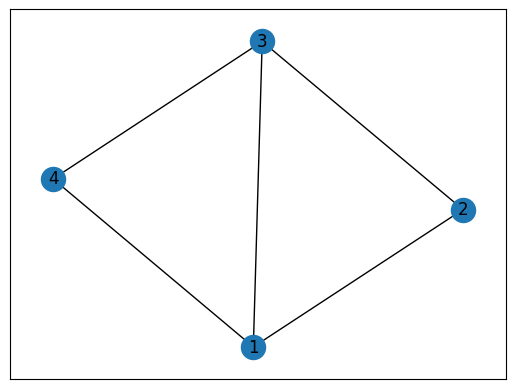

In [69]:
nx.draw_networkx(G)

In [70]:
model_1, G1 = generate_node_embeddings(clauses_1)

Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 2927.01it/s]

In [71]:
for node, _ in model_1.wv.most_similar('1'):
    print((node, _))

('38', 0.9588424563407898)
('40', 0.9527652263641357)
('39', 0.9416986107826233)
('41', 0.9407561421394348)
('2', 0.919468879699707)
('37', 0.9037676453590393)
('42', 0.8723822832107544)
('3', 0.8303126096725464)
('36', 0.7900413274765015)
('43', 0.7680306434631348)


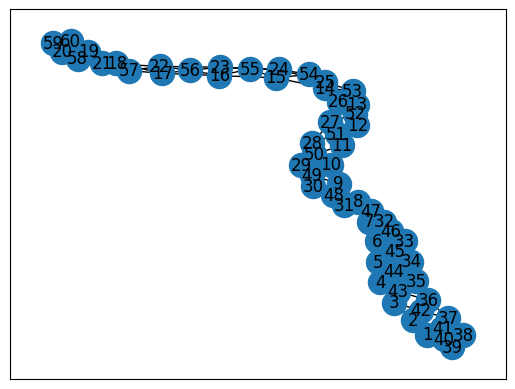

In [72]:
nx.draw_networkx(G1)

In [73]:
node_IDs = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors
print(node_IDs)
print(node_embeddings)

['1', '3', '2', '4']
[[-0.02062274  0.0134138   0.09803867  0.18269506 -0.1026478  -0.11913261
   0.09338225  0.29913226 -0.02640124 -0.10442421  0.15968     0.04929825
   0.19706301  0.08452439 -0.20604192 -0.12946112 -0.08659539  0.17851354
  -0.01707849 -0.04993055  0.10634568  0.11093183  0.30831343 -0.19869787
   0.07884096  0.1887144  -0.07899939  0.08544028 -0.03731152 -0.04102196
   0.0120257   0.03980199 -0.00796814 -0.2183665   0.03455056  0.08701657
  -0.072248    0.06731953  0.1963655  -0.09076086 -0.01797142 -0.00638824
  -0.20502946 -0.04603093 -0.00461094 -0.01227772 -0.08956779 -0.07399333
  -0.13824065  0.21625392 -0.01519011  0.20352033  0.01990546  0.20049247
   0.09744778 -0.14024812  0.05499132 -0.1767929   0.09967026 -0.14222543
   0.03332233 -0.06872343 -0.20848131 -0.09793905]
 [-0.01910755  0.00542469  0.07681303  0.18462884 -0.09071798 -0.10031943
   0.08378129  0.297754   -0.02957945 -0.1185699   0.141757    0.04085192
   0.20855665  0.08561998 -0.19414404 -0

In [74]:
nx.info(G)

C:\Users\user\AppData\Local\Temp\ipykernel_8940\1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 4 nodes and 5 edges'

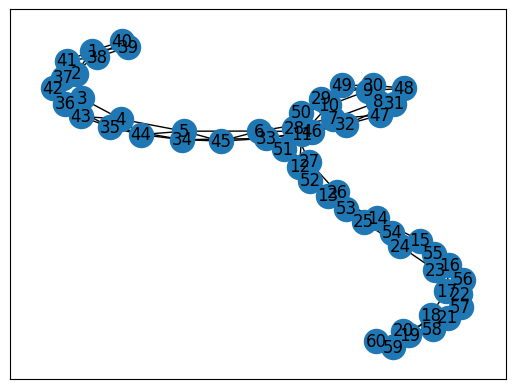

In [75]:
# nx.draw_networkx(G1)
nx.draw_networkx(G1)

In [80]:
# G.nodes
for i in G.nodes:
    for node, _ in model.wv.most_similar(f'{i}'):
        print((i, node, _))
    print("-----")

(1, '3', 0.9942744970321655)
(1, '4', 0.9878872632980347)
(1, '2', 0.9821951389312744)
-----
(2, '4', 0.988897442817688)
(2, '1', 0.9821950793266296)
(2, '3', 0.9818741083145142)
-----
(3, '1', 0.9942743182182312)
(3, '4', 0.9917247295379639)
(3, '2', 0.9818741679191589)
-----
(4, '3', 0.9917244911193848)
(4, '2', 0.9888973236083984)
(4, '1', 0.9878872632980347)
-----


In [85]:
for i in sorted(G1.nodes):
    print((i, model_1.wv.most_similar(f'{i}')[0]))
    # print("-----")

(1, ('38', 0.9588424563407898))
(2, ('41', 0.934104323387146))
(3, ('2', 0.907838761806488))
(4, ('43', 0.8988920450210571))
(5, ('45', 0.887715220451355))
(6, ('45', 0.8979954719543457))
(7, ('46', 0.8828234076499939))
(8, ('31', 0.8791307210922241))
(9, ('49', 0.8835208415985107))
(10, ('29', 0.8785802721977234))
(11, ('50', 0.885712206363678))
(12, ('51', 0.9088974595069885))
(13, ('53', 0.9125755429267883))
(14, ('54', 0.8920256495475769))
(15, ('54', 0.8974748849868774))
(16, ('56', 0.9098373651504517))
(17, ('56', 0.9257596135139465))
(18, ('21', 0.9347838163375854))
(19, ('20', 0.9608617424964905))
(20, ('19', 0.9608618021011353))
(21, ('58', 0.9369837641716003))
(22, ('57', 0.9196128249168396))
(23, ('55', 0.8936290144920349))
(24, ('15', 0.8900411128997803))
(25, ('54', 0.8887813091278076))
(26, ('52', 0.9032599329948425))
(27, ('52', 0.8825136423110962))
(28, ('51', 0.8871836066246033))
(29, ('30', 0.8953589200973511))
(30, ('49', 0.8980112075805664))
(31, ('47', 0.8822309374

In [157]:
def utworzSkierowanyGraf(G1, model_2):
    G2 = nx.DiGraph()
    for i in G1.nodes:
        node, waga = model_2.wv.most_similar(f'{i}')[0]
        # print(i, int(node), round(waga,2))
        G2.add_edge(i, int(node))  # Dodanie krawędzi z wagą 5
    # G2.add_edge(2, 3, weight=3)  # Dodanie krawędzi z wagą 3
    # G2.add_edge(3, 4, weight=7)  # Dodanie krawędzi z wagą 7

    # Rysowanie grafu
    # pos = nx.shell_layout(G2)
    pos = nx.spring_layout(G2, scale=10)
    # pos = nx.kamada_kawai_layout(G2)
    nx.draw(G2, pos, with_labels=True, node_size=150, arrowsize=20)
    # Dodanie etykiet krawędzi
    labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=labels)
    plt.show()

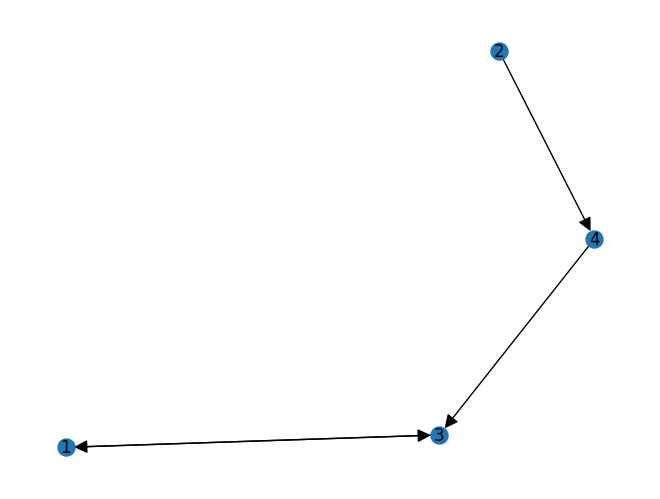

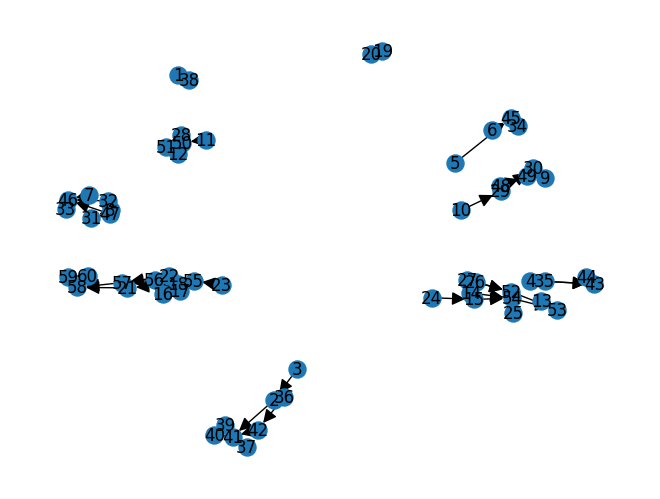

In [158]:
utworzSkierowanyGraf(G, model)
utworzSkierowanyGraf(G1, model_1)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 751.90it/s]


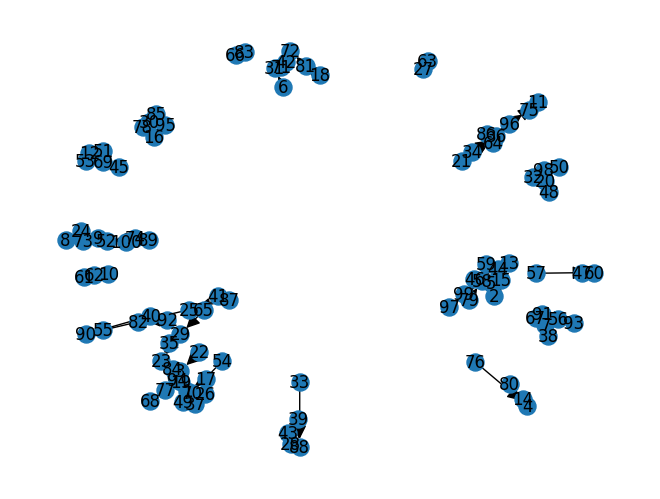

In [159]:
def cala_operacja(nazwa_pliku):
    num_vars, clauses = read_dimacs_cnf(nazwa_pliku)
    model, G = generate_node_embeddings(clauses)
    utworzSkierowanyGraf(G, model)

nazwa = "DIMACS_files/turbo_easy/example_2.cnf"
cala_operacja(nazwa)

In [156]:
nazwa = "DIMACS_files/easy/sat/Analiza1-itox_vc1033.cnf"
cala_operacja(nazwa)

Computing transition probabilities:  16%|█▌        | 18881/118528 [03:20<17:37, 94.23it/s]  


KeyboardInterrupt: 

Computing transition probabilities: 100%|██████████| 4614/4614 [00:13<00:00, 339.00it/s] 


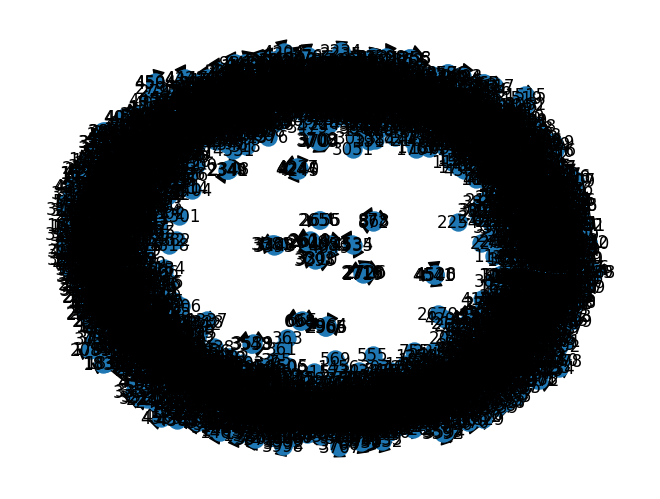

In [160]:
nazwa = "DIMACS_files/medium/unsat/Analiza1-AProVE07-08.cnf"
cala_operacja(nazwa)